# Para aumentar o display do Pandas

In [308]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 3554)

# Para resetar todas as configurações do Pandas:

In [309]:
import pandas as pd
pd.reset_option('all')

C:\Users\Enzo\AppData\Local\Temp\ipykernel_10736\2606737445.py:2: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
C:\Users\Enzo\AppData\Local\Temp\ipykernel_10736\2606737445.py:2: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


#  Análise de dados Nashira

In [310]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from IPython.display import Image
from rocketpy import Environment, SolidMotor, Rocket, Flight
import datetime

### Sistemas de Coordendas
Nos dados do foguete podemos encontrar 2 tipos de orientação. O sistema cartesiano e o sistema NED.

No sistema cartesiano consideraremos o eixo Z como vertical

No sistema NED teremos:

n: Norte

e: Leste

d: Para baixo

### Filtro de Kalman
É um filtro muito utilizado para reduzir o ruído em sistemas dinâmicos (como no vôo de um foguete). Usaremos a biblioteca FilterPy que disponibiliza diferentes versões de um filtro da Kalman

O filtro de Kalman realiza predições a partir de estados passados

### Low-pass e High-pass filter

Obter valores por integração reduz o ruído -> low-pass filter
Obter valores por derivação aumenta o ruído (deriva temporal, etc) -> high-pass filter

### Transformando CSV em dataframe

In [311]:
df = pd.read_csv("nashira_telemetry.csv", decimal = ",")
timestamp = df.columns[0] #primeira coluna
df.set_index(timestamp) #indexamos para realizar buscas
df.columns = [x.lower() for x in df.columns] #formata todas as colunas para minúsculo

### Removendo colunas vazias

- As colunas de validação (imu_valid, ekf_valid, etc) não tem nenhum dado em todo o CSV por isso serão droppadas

In [312]:
colunas_para_checar = df.columns[32:37] #vamos ver se as colunas da 32 à 37 estão totalmente vazias
for col in colunas_para_checar:
    if df[col].isna().all():
        df = df.drop(columns=col,axis= "columns") #se estiverem vazias droppa as colunas

### Checagem do GPS

- Para simplificar vou criar uma coluna auxiliar à gnss_fix, onde ela indicará apenas se há sinal de gps (1) ou se não há (0)

In [313]:
df['gps_available'] = df['gnss_fix'] > 0

### Formatação dos timestamps

- Para simplificar a leitura vamos usar o intervalo de tempo do lançamento ao invés das timestamps nos gráficos

In [314]:
df['time_interval'] = df['timestamp_ms'] - df['timestamp_ms'][0]

### Criticando os dados
- Temos os dados da altitude do GPS e a do Barômetro. Vamos plottar ambos e identificar se há inconsistência na medição de alguma
- Vamos usar também os dados de pressão para ver se há alguma discrepância de cálculo.
- Como está no NED, pos_d terá medidas negativas

*Consideraremos a pressão em hPa, pois além de gerar números plausíveis, também é uma das medidas mais usadas por sensores de telemetria

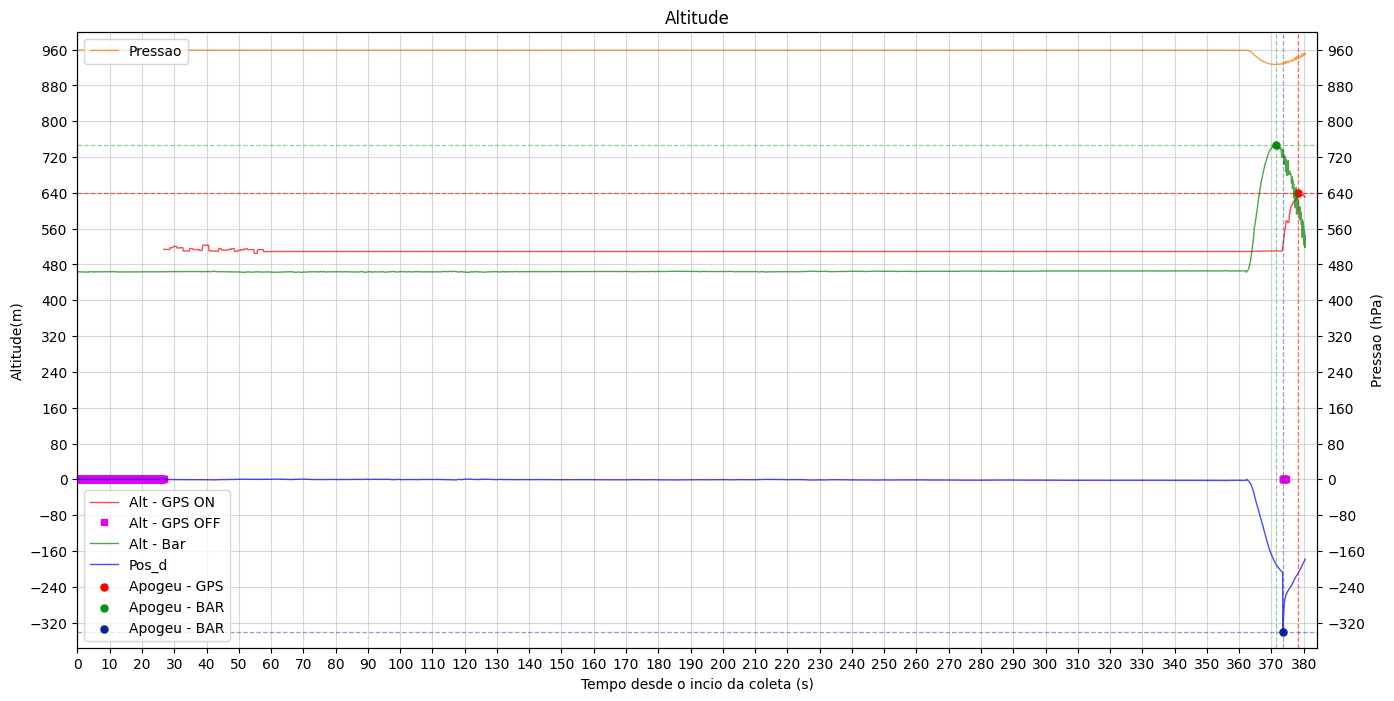

Altitude Apogeu GPS (ASL): 640.3m
Altitude Apogeu BAR (ASL): 746.2m
Altitude Relativa Apogeu POS_D (AGL): -341.8969m
Tempo Apogeu GPS: 378.304s
Tempo Apogeu BAR: 371.392s
Tempo Apogeu POS_D: 373.544s
Velocidade Vertical Apogeu GPS: 4175.7085m/s
Velocidade Vertical Apogeu BAR: -9531.3936m/s
Velocidade Vertical Apogeu POS_D: -7004.5176m/s


In [315]:
df_alt = df[["time_interval", "alt_gps", "alt_bar", "pressure", "gps_available", "pos_d"]].copy()
df_alt["time_interval"] = (df_alt["time_interval"]/1000)

df_gps_on = df_alt[df_alt["gps_available"] == 1]
df_gps_off = df_alt[df_alt["gps_available"] == 0]

#Valores máximos dos eixos
max_x = df_alt["time_interval"].max()

#Criando o eixo x (tempo)
figure, axe1 = plt.subplots(figsize=(16,8))
axe1.set_xlabel("Tempo desde o incio da coleta (s)")
axe1.set_xlim(-0.01,1.01*max_x)
axe1.xaxis.set_major_locator(ticker.MaxNLocator(40))

#Criando o primeiro eixo y (altitude)
axe1.plot(df_gps_on["time_interval"], df_gps_on["alt_gps"], color ="r", linestyle="-",label ="Alt - GPS ON ", alpha = 0.7, linewidth = 1)
axe1.plot(df_gps_off["time_interval"], df_gps_off["alt_gps"], 's',  color ="#E400E8", label="Alt - GPS OFF", markersize=4, alpha= 1)
axe1.plot(df_alt["time_interval"],df_alt["alt_bar"], color ="g", linestyle="-",label ="Alt - Bar", alpha = 0.7, linewidth = 1)
axe1.plot(df_alt["time_interval"],df_alt["pos_d"], color="b", linestyle="-", label="Pos_d", alpha=0.7, linewidth=1)

axe1.set_ylabel("Altitude(m)")
axe1.set_ylim(1.1*df_alt["pos_d"].min(),1000)
axe1.grid(True, alpha=0.5)
axe1.yaxis.set_major_locator(ticker.MaxNLocator(22))

#Marcando o apogeu
df_apogeu = (df[["timestamp_ms","time_interval","alt_gps","alt_bar","pos_d", "vel_d"]]).copy() #Usamos o dataframe completo para determinar o apogeu

alt_ap_gps = df_apogeu["alt_gps"].max() #em metros
alt_ap_bar = df_apogeu["alt_bar"].max()
alt_ap_posd = df_apogeu["pos_d"].min()

id_apogeu_gps = df_apogeu["alt_gps"].idxmax()
id_apogeu_bar = df_apogeu["alt_bar"].idxmax()
id_apogeu_posd = df_apogeu["pos_d"].idxmin()

timestamp_ap_gps = df_apogeu["timestamp_ms"].iloc[id_apogeu_gps] #em ms
timestamp_ap_bar = df_apogeu["timestamp_ms"].iloc[id_apogeu_bar]
timestamp_ap_posd = df_apogeu["timestamp_ms"].iloc[id_apogeu_posd]

time_interval_ap_gps = df_apogeu["time_interval"].iloc[id_apogeu_gps] #em ms
time_interval_ap_bar = df_apogeu["time_interval"].iloc[id_apogeu_bar]
time_interval_ap_posd = df_apogeu["time_interval"].iloc[id_apogeu_posd]

vel_d_ap_gps = df_apogeu["vel_d"].iloc[id_apogeu_gps]
vel_d_ap_bar = df_apogeu["vel_d"].iloc[id_apogeu_bar]
vel_ap_pos_d = df_apogeu["vel_d"].iloc[id_apogeu_posd]

time_interval_ap_gps /= 1000
time_interval_ap_bar /= 1000
time_interval_ap_posd /= 1000

axe1.axvline(x=time_interval_ap_gps, color="#FD00009C", linewidth = 0.9, linestyle = "--")
axe1.axhline(y=alt_ap_gps, color="#FD00009C", linewidth = 0.9, linestyle = "--")
axe1.scatter(x=time_interval_ap_gps, y=alt_ap_gps, color="#FD00009C", linewidths= 0.1, alpha=1, label = "Apogeu - GPS")
axe1.axvline(x=time_interval_ap_bar, color="#07941371", linewidth = 0.9, linestyle = "--")
axe1.axhline(y=alt_ap_bar, color="#07941371", linewidth = 0.9, linestyle = "--")
axe1.scatter(x=time_interval_ap_bar, y=alt_ap_bar, color="#07941371", linewidths= 0.1, alpha=1, label = "Apogeu - BAR")
axe1.axvline(x=time_interval_ap_posd, color="#07289470", linewidth = 0.9, linestyle = "--")
axe1.axhline(y=alt_ap_posd, color="#07289470", linewidth = 0.9, linestyle = "--")
axe1.scatter(x=time_interval_ap_posd, y=alt_ap_posd, color="#07289470", linewidths= 0.1, alpha=1, label = "Apogeu - BAR")



#Criando o segundo eixo y (pressao)
axe2 = axe1.twinx()
axe2.plot(df_alt["time_interval"],df_alt["pressure"], color ="#F97400FF", linestyle="-",label ="Pressao", alpha = 0.7, linewidth = 1)
axe2.set_ylabel("Pressao (hPa)")
axe2.set_ylim(1.1*df_alt["pos_d"].min(),1000)
axe2.grid(False)
axe2.legend(loc = "upper left")
axe2.yaxis.set_major_locator(ticker.MaxNLocator(22))


plt.title("Altitude")
axe1.legend(loc= "lower left")
plt.show()
print(f"Altitude Apogeu GPS (ASL): {alt_ap_gps}m")
print(f"Altitude Apogeu BAR (ASL): {alt_ap_bar}m")
print(f"Altitude Relativa Apogeu POS_D (AGL): {alt_ap_posd}m")
print(f"Tempo Apogeu GPS: {time_interval_ap_gps}s")
print(f"Tempo Apogeu BAR: {time_interval_ap_bar}s")
print(f"Tempo Apogeu POS_D: {time_interval_ap_posd}s")
print(f"Velocidade Vertical Apogeu GPS: {vel_d_ap_gps}m/s")
print(f"Velocidade Vertical Apogeu BAR: {vel_d_ap_bar}m/s")
print(f"Velocidade Vertical Apogeu POS_D: {vel_ap_pos_d}m/s")

*Analisando discrepâncias das medidas do GPS e BAR

- Vamos plottar um gráfico do "offset" entre as medidas do GPS e do Barômetro

Pico offsett: 373.468s desde o incio da coleta


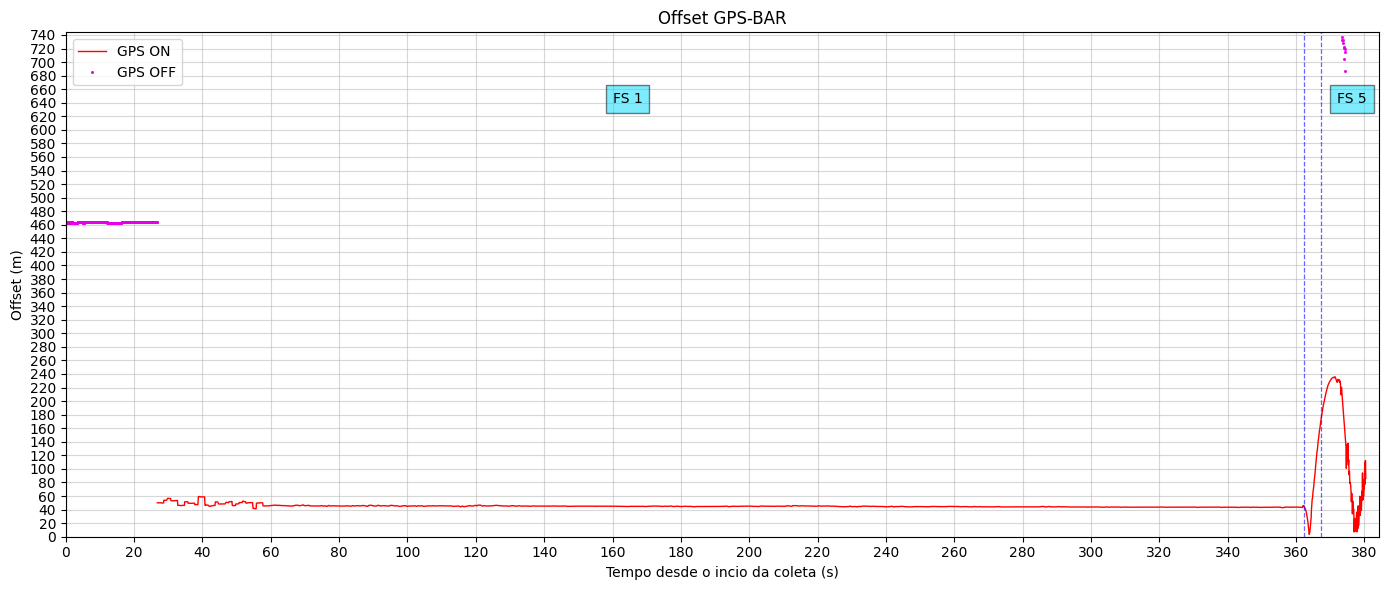

In [316]:
df_offset = df[(["time_interval","alt_gps", "alt_bar", "gps_available"])].copy()

#Calculo o OFFSET de cada medição
df_offset[["alt_gps", "alt_bar"]] = df_offset[["alt_gps", "alt_bar"]].astype("float32")
df_offset["offset"] = (abs(df_offset["alt_bar"] - df_offset["alt_gps"]))

#Deixa o tempo em segundos
df_offset["time_interval"] = df_offset["time_interval"]/1000

plt.figure(figsize=(14,6))

#Cria um df para pontos com e sem sinal de GPS
df_gps_on = (df_offset[df_offset["gps_available"] == 1])
df_gps_off = (df_offset[df_offset["gps_available"] == 0])

#Checa se não há duplicatas
n_total = len(df_offset)
n_filtros = len(df_gps_off) + len(df_gps_on)
if n_filtros != n_total:
    print(f"Erro: soma dos filtros ({n_filtros}) não bate com total! ({n_total})")

#Plot do Offset
plt.plot(df_gps_on["time_interval"], df_gps_on["offset"],color ="r", linestyle="-", linewidth = 1, label = "GPS ON") 

#Plot dos pontos com GPS off
plt.plot(df_gps_off["time_interval"], df_gps_off["offset"], 's',  color ="#E400E8", label="GPS OFF", markersize=1, alpha= 1)

#Separação por flight_state
state1_fim = ((df["flight_state"].eq(2)).idxmax()) - 1
state3_fim = ((df["flight_state"].eq(5)).idxmax()) - 1


plt.axvline(x=(df["time_interval"].iloc[state1_fim])/1000, color="#1100FD9C", linewidth = 0.9, linestyle = "--")
plt.axvline(x=(df["time_interval"].iloc[state3_fim])/1000, color="#1100FD9C", linewidth = 0.9, linestyle = "--")


plt.text(160, 640, 'FS 1',
        bbox={'facecolor': '#00DBFD9C', 'alpha': 0.5, 'pad': 5})

plt.text(372, 640, 'FS 5',
        bbox={'facecolor': "#00DBFD9C", 'alpha': 0.5, 'pad': 5})
#Ajusta o eixo x
plt.xlim(-0.01*df_offset["time_interval"].min(), 1.01*df_offset["time_interval"].max())
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(20)) #O num de valores nos eixos foi decidido de forma à deixarclaro identificação do valor mais alto nele

#Ajusta o eixo y
plt.ylim(-0.01*df_offset["offset"].min(), 1.01*df_offset["offset"].max())
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(46))


plt.title("Offset GPS-BAR")
plt.xlabel("Tempo desde o incio da coleta (s)")
plt.ylabel("Offset (m)")

plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()

id_pico_offsett = df_offset["offset"].idxmax()
print(f"Pico offsett: {df_offset["time_interval"].iloc[id_pico_offsett]}s desde o incio da coleta")
plt.show()


Note que o OFFSET tem um comportamento constante (ideal) em boa parte do tempo em que o GPS funciona - isso indica que nossas medições de altitude por bar e pelo GPS podem ser usadas em conjunto para estimar dados quando o offset é considerado

Além disso, note que por volta dos ~365s temos uma região de alta incerteza. Nesse intervalo o GPS perde sinal e há uma queda abrupta de pressão, o que torna difícil concluir se o gps ou o barômetro apresentam medições confiáveis

Após o GPS recuperar o sinal o offset continua aumentando -> Veremos mais à frente que o momento de pico desse offset coincide com o apogeu - Provavelmente é uma diferença de pressão gerada pela liberação do paraquedas

-MARCAR NOS GRÁFICOS: APOGEU (MAIOR ALTITUDE), BURNOUT(ACCEL = 0, VEL CAI, FLIGHT_STATE MUDA), LANDING(ALTITUDE RELATIVA PROX À 0)

- Agora, iremos separar os plots com base no flight state e considerar o TEMPO DECORRIDO e a ALTITUDE GANHA desde o ínicio do STATE, para podermos analisar a variação da altitude em função do tempo

- Atenção!!!
Os dados de GPS e BARÔMETRO são dados num formato "above sea level" enquanto os dados de POS_D são "above ground level" (AGL)

State: 1
t0: 0.0s
tf: 362.328s
time_min: 0.0s
time_max: 362.328s
duracao: 362.33s
-------------------------------------
State: 2
Altitude de lancamento encontrada! (GPS): 509.16
t0: 362.509s
tf: 364.265s
time_min: 362.509s
time_max: 364.265s
duracao: 1.76s
-------------------------------------
State: 3
t0: 364.444s
tf: 367.324s
time_min: 364.444s
time_max: 367.324s
duracao: 2.88s
-------------------------------------
State: 5
t0: 367.437s
tf: 380.434s
time_min: 367.437s
time_max: 380.434s
duracao: 13.0s
-------------------------------------
apogeu_gps (ASL): 640.3m
apogeu_gps_time: 378.304s
apogeu_bar (ASL): 746.2m
apogeu_bar_time: 371.392s
apogeu_pos_d (AGL): 341.8969m
apogeu_pos_d_time: 373.544s


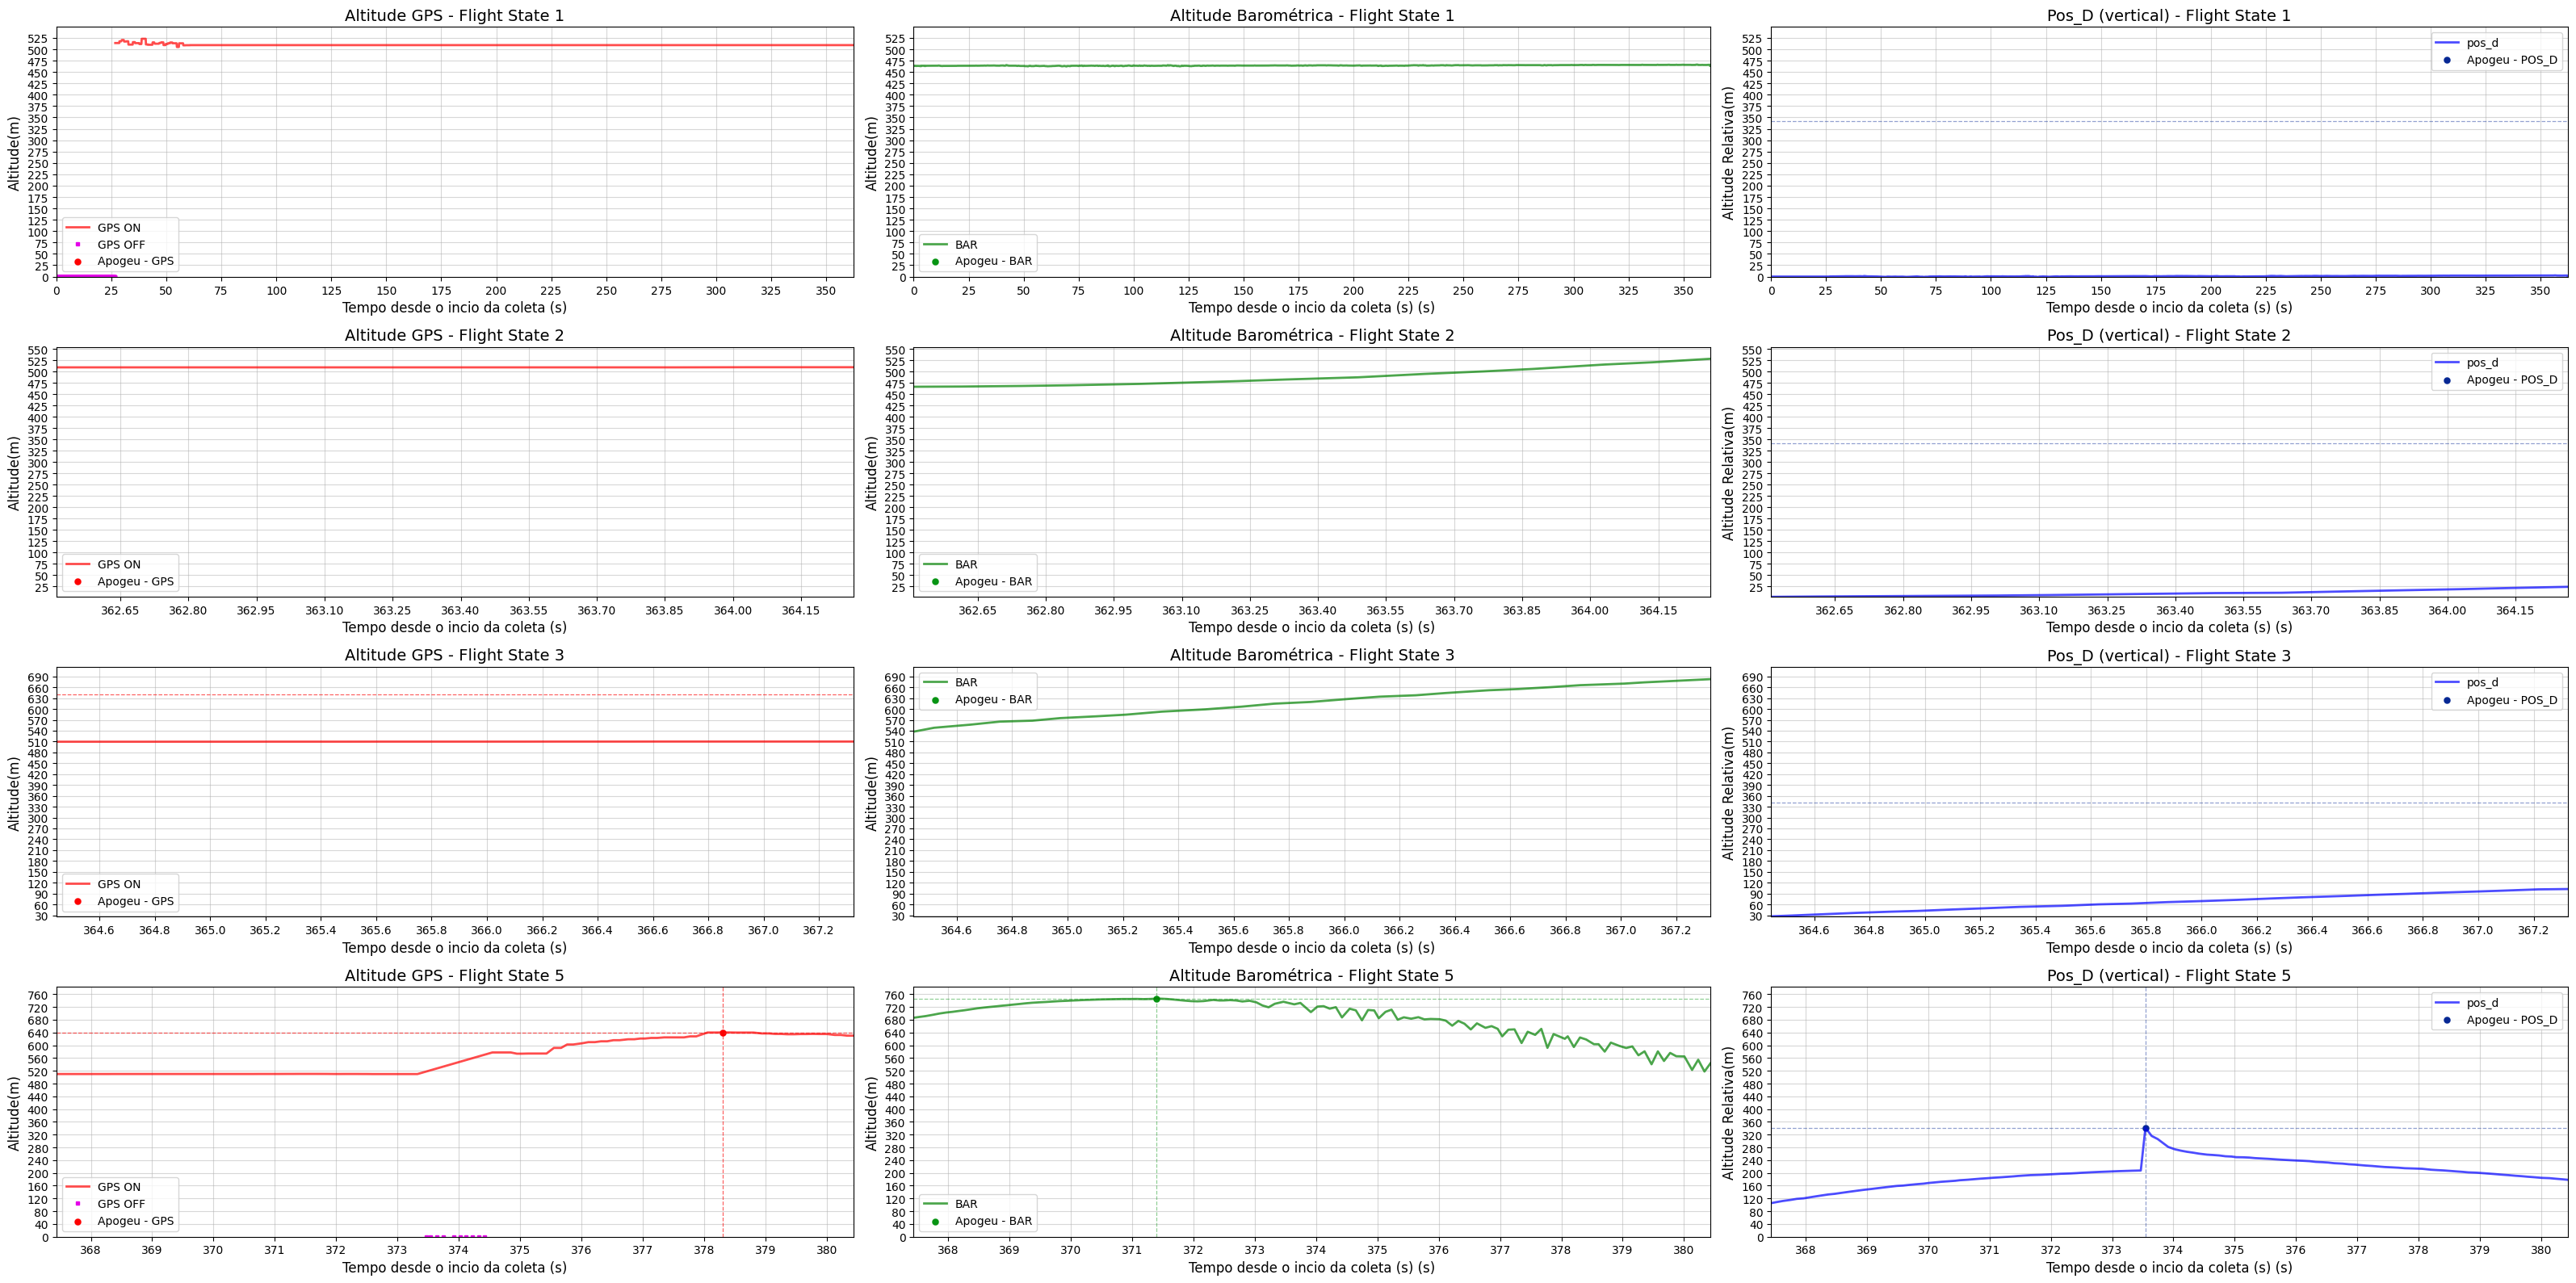

In [317]:
states = df["flight_state"].unique()
n_states = len(states) #sabemos que temos 4 flight_states [1,2,3,5]

figure, axes = plt.subplots(n_states,3, figsize=(32,4*n_states)) #Teremos 2 gráficos (GPS e BAR) por "linha", cada linha representa 1 state

for i, state in enumerate(states):
    df_state = df[df["flight_state"] == state].copy() #Copiamos só o flight state atual
    df_state["time_interval"] = (df_state["time_interval"]/1000)
    df_state["pos_d"] = df_state["pos_d"] * (-1) 
    print(f"State: {state}")
    if state == 2: #pos_d começa a aumentar em no state 2
        print(f"Altitude de lancamento encontrada! (GPS): {df_state["alt_gps"].iloc[0:100].mean()}") #Média para tentar compensar o ruído
    print(f"t0: {df_state["time_interval"].min()}s")
    print(f"tf: {df_state["time_interval"].max()}s")

    #Se não houver nada no state pula ele
    if len(df_state) == 0:
        continue
    
    #Cria um df para pontos com e sem sinal de GPS
    df_gps_on_state = df_state[df_state["gps_available"] == 1] #Pontos em que já sinal de GPS
    df_gps_off_state = df_state[df_state["gps_available"] == 0]#Pontos em que não há sinal de GPS

    #Checamos se não há duplicatas
    n_total = len(df_state)
    n_filtros = len(df_gps_on_state) + len(df_gps_off_state)
    if n_filtros != n_total:
        print(f"Erro no state {state}: soma dos filtros ({n_filtros}) não bate com total! ({n_total})")

    #Ordenamos os df por tempo
    df_gps_on_state = df_gps_on_state.sort_values("time_interval")
    df_gps_off_state = df_gps_off_state.sort_values("time_interval")

    #Coluna 1 - GPS
    if len(df_gps_on_state) > 0: #Para os pontos com sinal de GPS
        axes[i,0].plot(df_gps_on_state["time_interval"], df_gps_on_state["alt_gps"], color ="r", linestyle="-",label ="GPS ON", alpha = 0.7, linewidth = 2)

    if len(df_gps_off_state) > 0: #Para os pontos sem sinal de GPS
        axes[i,0].plot(df_gps_off_state["time_interval"], df_gps_off_state["alt_gps"], 's',  color ="#E400E8", label="GPS OFF", markersize=3, alpha= 1)

    #Marcando o apogeu
    df_apogeu = (df[["timestamp_ms","time_interval","alt_gps","alt_bar","pos_d"]]).copy() #Usamos o dataframe completo para determinar o apogeu
    df_apogeu["pos_d"] = abs(df_apogeu["pos_d"]) #precisamos usar o módulo aqui também

    alt_ap_gps = df_apogeu["alt_gps"].max() #em metros
    alt_ap_bar = df_apogeu["alt_bar"].max()
    alt_ap_posd = df_apogeu["pos_d"].max()

    id_apogeu_gps = df_apogeu["alt_gps"].idxmax()
    id_apogeu_bar = df_apogeu["alt_bar"].idxmax()
    id_apogeu_posd = df_apogeu["pos_d"].idxmax()


    timestamp_ap_gps = df_apogeu["timestamp_ms"].iloc[id_apogeu_gps] #em ms
    timestamp_ap_bar = df_apogeu["timestamp_ms"].iloc[id_apogeu_bar]
    timestamp_ap_posd = df_apogeu["timestamp_ms"].iloc[id_apogeu_posd]

    time_interval_ap_gps = df_apogeu["time_interval"].iloc[id_apogeu_gps] #em ms
    time_interval_ap_bar = df_apogeu["time_interval"].iloc[id_apogeu_bar]
    time_interval_ap_posd = df_apogeu["time_interval"].iloc[id_apogeu_posd]

    time_interval_ap_gps /= 1000
    time_interval_ap_bar /= 1000
    time_interval_ap_posd /= 1000

    axes[i,0].axvline(x=time_interval_ap_gps, color="#FD00009C", linewidth = 0.9, linestyle = "--")
    axes[i,0].axhline(y=alt_ap_gps, color="#FD00009C", linewidth = 0.9, linestyle = "--")
    axes[i,0].scatter(x=time_interval_ap_gps, y=alt_ap_gps,  color="#FD00009C", linewidths= 0.1, alpha=1, label = "Apogeu - GPS")


    #Detalhes - Coluna 1
    axes[i,0].set_title(f"Altitude GPS - Flight State {state}", fontsize = 14)
    axes[i,0].set_xlabel('Tempo desde o incio da coleta (s)', fontsize = 12)
    axes[i,0].set_ylabel('Altitude(m)', fontsize = 12)
    axes[i,0].legend()
    axes[i,0].grid(True, alpha=0.5)

    #Ajusta o eixo x
    time_min = (df_state["time_interval"].min())
    time_max = (df_state["time_interval"].max())

    print(f"time_min: {time_min}s")
    print(f"time_max: {time_max}s")

    axes[i,0].set_xlim(time_min,time_max)
    axes[i,0].xaxis.set_major_locator(ticker.MaxNLocator(16))

    #Ajusta o eixo y
    alt_min = min(df_state["alt_gps"].min(), df_state["alt_bar"].min(), df_state["pos_d"].min())
    alt_max = max(df_state["alt_gps"].max(), df_state["alt_bar"].max(), df_state["pos_d"].max())

    print(f"duracao: {round(time_max-time_min,2)}s")
    print("-------------------------------------")

    axes[i,0].set_ylim(0.95*alt_min,1.05*alt_max)
    axes[i,0].yaxis.set_major_locator(ticker.MaxNLocator(25))

    #Coluna 2 - BAR
    axes[i,1].plot(df_state["time_interval"], df_state["alt_bar"], color ="g", linestyle="-",label ="BAR", alpha = 0.7, linewidth = 2)

    #Marcando o apogeu
    axes[i,1].axvline(x=time_interval_ap_bar, color="#07941371", linewidth = 0.9, linestyle = "--")
    axes[i,1].axhline(y=alt_ap_bar, color="#07941371", linewidth = 0.9, linestyle = "--")
    axes[i,1].scatter(x=time_interval_ap_bar, y=alt_ap_bar, color="#07941371", linewidths= 0.1, alpha=1, label = "Apogeu - BAR")

    #Detalhes - Coluna 2
    axes[i,1].set_title(f"Altitude Barométrica - Flight State {state}", fontsize = 14)
    axes[i,1].set_xlabel('Tempo desde o incio da coleta (s) (s)', fontsize = 12)
    axes[i,1].set_ylabel('Altitude(m)', fontsize = 12)
    axes[i,1].legend()
    axes[i,1].grid(True, alpha=0.5)

    #Ajusta o eixo x
    axes[i,1].set_xlim(time_min,time_max)
    axes[i,1].xaxis.set_major_locator(ticker.MaxNLocator(16))

    #Ajusta o eixo y
    axes[i,1].set_ylim(0.95*alt_min,1.05*alt_max)
    axes[i,1].yaxis.set_major_locator(ticker.MaxNLocator(25))


    #Coluna 3 - pos_d (altitude)
    axes[i,2].plot(df_state["time_interval"], df_state["pos_d"], color ="b", linestyle="-",label ="pos_d", alpha = 0.7, linewidth = 2)

    #Marcando o apogeu
    axes[i,2].axvline(x=time_interval_ap_posd, color="#07289470", linewidth = 0.9, linestyle = "--")
    axes[i,2].axhline(y=alt_ap_posd, color="#07289470", linewidth = 0.9, linestyle = "--")
    axes[i,2].scatter(x=time_interval_ap_posd, y=alt_ap_posd, color="#07289470", linewidths= 0.1, alpha=1, label = "Apogeu - POS_D")

    #Detalhes - Coluna 3
    axes[i,2].set_title(f"Pos_D (vertical) - Flight State {state}", fontsize = 14)
    axes[i,2].set_xlabel('Tempo desde o incio da coleta (s) (s)', fontsize = 12)
    axes[i,2].set_ylabel('Altitude Relativa(m)', fontsize = 12)
    axes[i,2].legend()
    axes[i,2].grid(True, alpha=0.5)

    #Ajusta o eixo x
    axes[i,2].set_xlim(time_min,time_max)
    axes[i,2].xaxis.set_major_locator(ticker.MaxNLocator(16))

    #Ajusta o eixo y
    axes[i,2].set_ylim(0.95*alt_min,1.05*alt_max)
    axes[i,2].yaxis.set_major_locator(ticker.MaxNLocator(25))

print(f"apogeu_gps (ASL): {alt_ap_gps}m")
print(f"apogeu_gps_time: {time_interval_ap_gps}s")
print(f"apogeu_bar (ASL): {alt_ap_bar}m")
print(f"apogeu_bar_time: {time_interval_ap_bar}s")
print(f"apogeu_pos_d (AGL): {alt_ap_posd}m")
print(f"apogeu_pos_d_time: {time_interval_ap_posd}s")

plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

- Atente-se que houve uma perda de conexão com o GNSS na fase 5
- É preciso tratar os ruídos que estão distorcendo o eixo Y na fase 1 e 5 (sugestão de usar Savitzky-Golay)


- A partir da análise de altitude podemos deduzir algumas fases do vôo:


       Fase 1: Ground State - note que nenhum sensor capta variação de altitude significativa 

*acc_ned está fora do sistema NED?

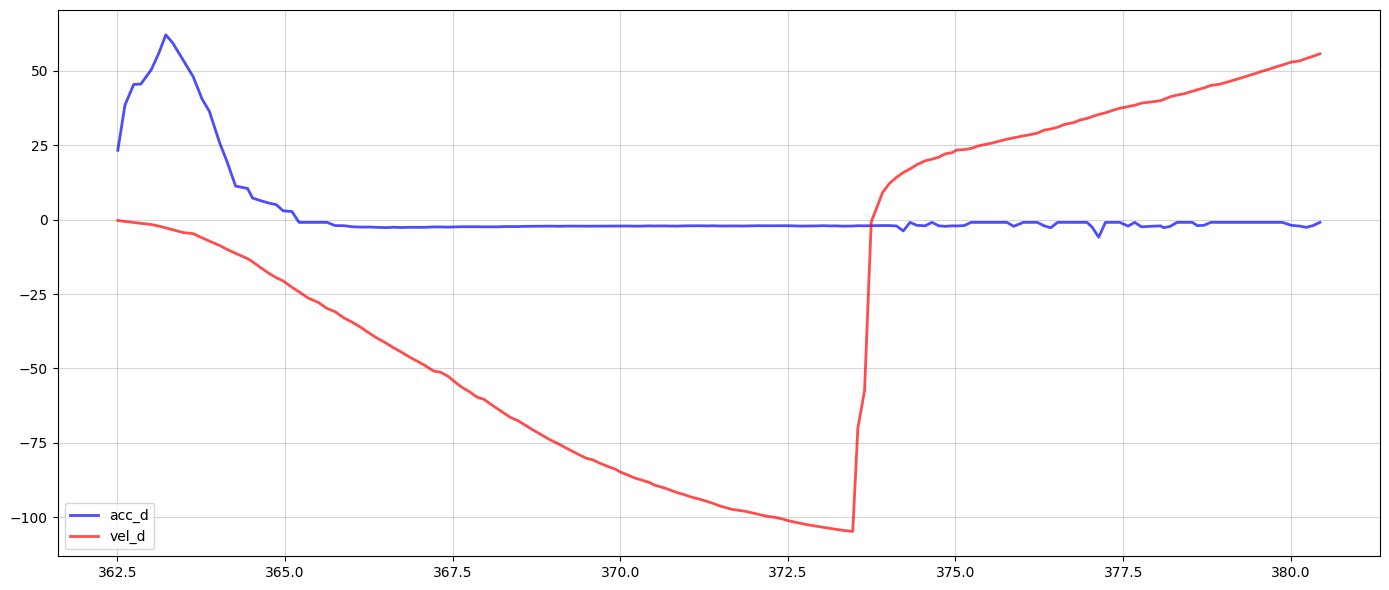

In [318]:
plt.figure(figsize=(14,6))
#Excluindo o flight_state 1 (ground state)
df_teste = df[["flight_state", "acc_n", "acc_x_raw", "acc_e", "acc_y_raw","acc_d", "acc_z_raw", "time_interval", "vel_d"]]
df_teste = df_teste[df_teste["flight_state"] >= 2]

plt.plot(df_teste["time_interval"]/1000,df_teste["acc_d"], color ="b", linestyle="-",label ="acc_d", alpha = 0.7, linewidth = 2)
plt.plot(df_teste["time_interval"]/1000,df_teste["vel_d"]/100, color ="#FF0000", linestyle="-",label ="vel_d", alpha = 0.7, linewidth = 2)

plt.grid(True, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

- Note como um aumento positivo em acc_d (aceleração apontando para baixo) causa um aumento negativo em vel_d (corpo se movimenta para cima). Isso é fisicamente impossível, portanto assumiremos que acc_d está com o sentido oposto e usaremos acc_d*(-1) como a aceleração vertical no sistema NED

*Comparação acc_ned e acc_raw

Para sabermos se a aceleração rotacionada para o sistema NED está sendo calculada corretamente é interessante contrapor os dados brutos com os tratados


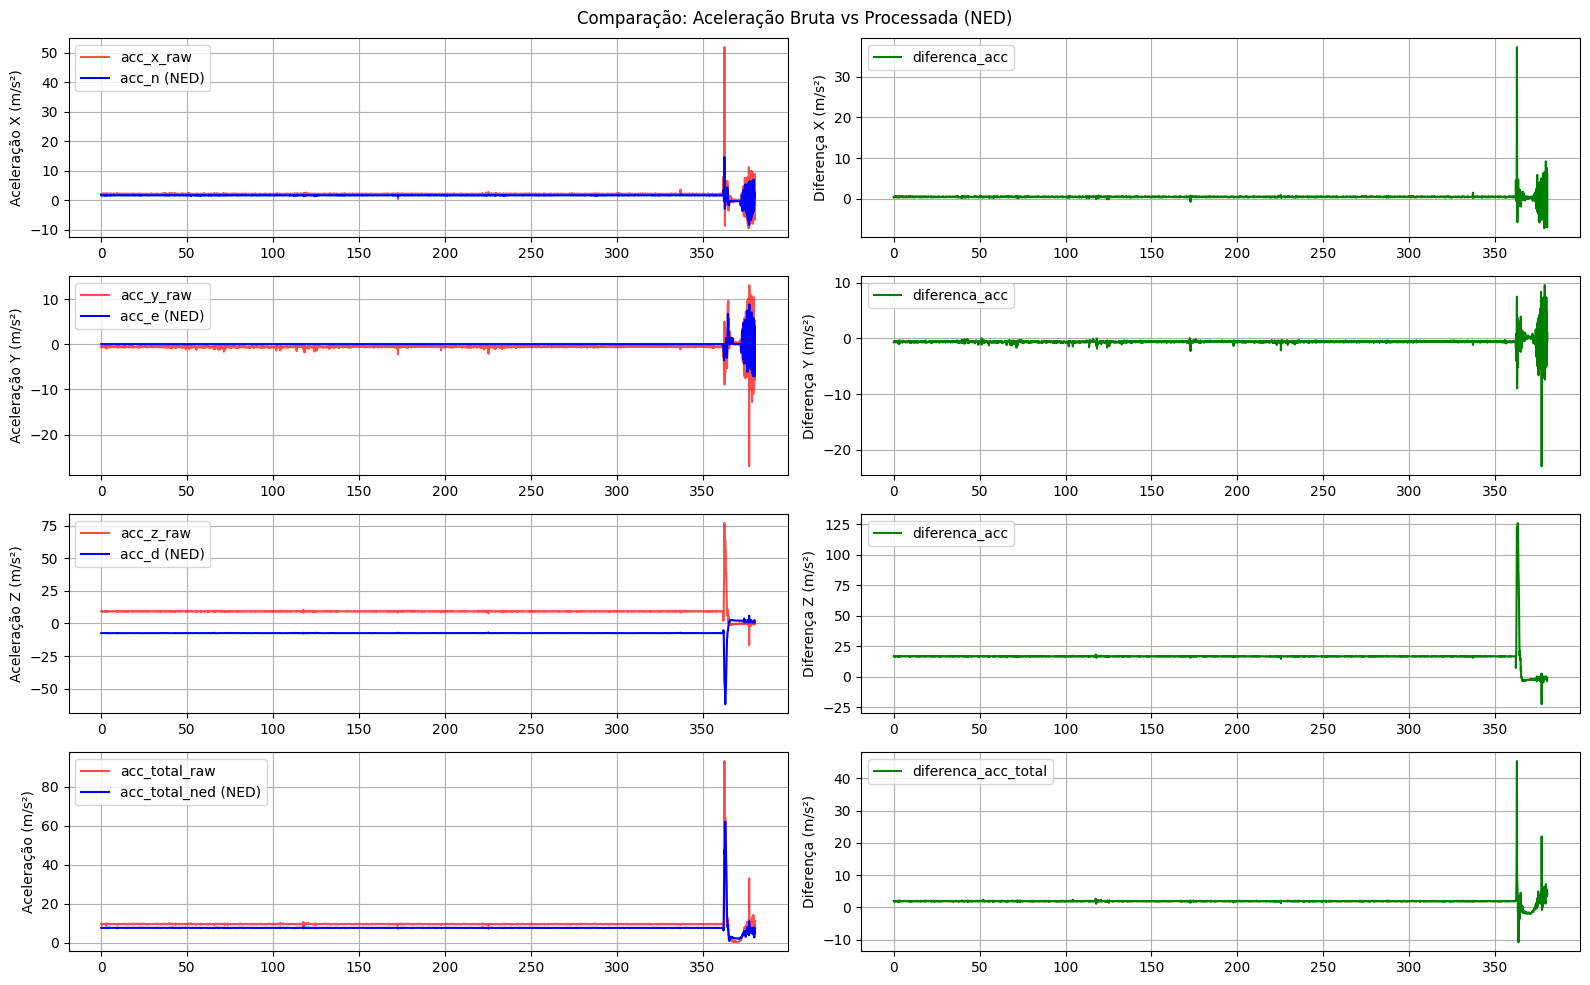

In [319]:
fig, axes = plt.subplots(4, 2, figsize=(16, 10))

df_acc = df[["flight_state", "acc_n", "acc_x_raw", "acc_e", "acc_y_raw","acc_d", "acc_z_raw", "time_interval", "vel_d"]].copy()
time_interval_s = df_acc['time_interval'] / 1000
df_acc["acc_d"] = (-1)*df_acc["acc_d"]
#Transformando acc_raw de g's para m/s²
g = 9.80665
df_acc['acc_x_raw_ms2'] = df_acc['acc_x_raw'] * g
df_acc['acc_y_raw_ms2'] = df_acc['acc_y_raw'] * g
df_acc['acc_z_raw_ms2'] = df_acc['acc_z_raw'] * g

# Encontrando a magnitude da aceleracao
df_acc['acc_total_raw'] = np.sqrt(df_acc['acc_x_raw_ms2']**2 + 
                              df_acc['acc_y_raw_ms2']**2 + 
                              df_acc['acc_z_raw_ms2']**2)

df_acc['acc_total_ned'] = np.sqrt(df_acc['acc_n']**2 + 
                              df_acc['acc_e']**2 + 
                              df_acc['acc_d']**2)


# Coluna 1 - Eixo z
axes[0,0].plot(time_interval_s, df_acc['acc_x_raw_ms2'], color="r", linestyle ="-", alpha=0.7, label='acc_x_raw')
axes[0,0].plot(time_interval_s, df_acc['acc_n'], color="b", linestyle ="-", label='acc_n (NED)')
axes[0,0].set_ylabel('Aceleração X (m/s²)')
axes[0,0].legend()
axes[0,0].grid(True)

axes[0,1].plot(time_interval_s, df_acc['acc_x_raw_ms2'] - df_acc['acc_n'], color="g", linestyle ="-", label='diferenca_acc')
axes[0,1].set_ylabel('Diferença X (m/s²)')
axes[0,1].legend()
axes[0,1].grid(True)

# Coluna 2 - Eixo y
axes[1,0].plot(time_interval_s, df_acc['acc_y_raw_ms2'], color="r", linestyle ="-", alpha=0.7, label='acc_y_raw')
axes[1,0].plot(time_interval_s, df_acc['acc_e'], color="b", linestyle ="-", label='acc_e (NED)')
axes[1,0].set_ylabel('Aceleração Y (m/s²)')
axes[1,0].legend()
axes[1,0].grid(True)

axes[1,1].plot(time_interval_s, df_acc['acc_y_raw_ms2'] - df_acc['acc_e'], color="g", linestyle ="-", label='diferenca_acc')
axes[1,1].set_ylabel('Diferença Y (m/s²)')
axes[1,1].legend()
axes[1,1].grid(True)

# Coluna 3 - Eixo z
axes[2,0].plot(time_interval_s, df_acc['acc_z_raw_ms2'], color="r", linestyle ="-", alpha=0.7, label='acc_z_raw')
axes[2,0].plot(time_interval_s, df_acc['acc_d'], color="b", linestyle ="-", label='acc_d (NED)')
axes[2,0].set_ylabel('Aceleração Z (m/s²)')
axes[2,0].legend()
axes[2,0].grid(True)

axes[2,1].plot(time_interval_s, df_acc['acc_z_raw_ms2'] - df_acc['acc_d'], color="g", linestyle ="-", label='diferenca_acc') #Inverteremos o sentido de acc_d para encontrar o "offset" entre as duas medidas, pois acc_z_raw equivale à -acc_d
axes[2,1].set_ylabel('Diferença Z (m/s²)')
axes[2,1].legend()
axes[2,1].grid(True)

#Coluna 4 - Magnitude da aceleracao
axes[3,0].plot(time_interval_s, df_acc['acc_total_raw'], color="r", linestyle ="-", alpha=0.7, label='acc_total_raw')
axes[3,0].plot(time_interval_s, df_acc['acc_total_ned'], color="b", linestyle ="-", label='acc_total_ned (NED)')
axes[3,0].set_ylabel('Aceleração (m/s²)')
axes[3,0].legend()
axes[3,0].grid(True)

axes[3,1].plot(time_interval_s, df_acc['acc_total_raw'] - df_acc['acc_total_ned'], color="g", linestyle ="-", label='diferenca_acc_total')
axes[3,1].set_ylabel('Diferença (m/s²)')
axes[3,1].legend()
axes[3,1].grid(True)

plt.suptitle('Comparação: Aceleração Bruta vs Processada (NED)')
plt.tight_layout()
plt.show()

O dados de acc_ned são dados processados. Neles são compensandas forças como a gravidade e há uma fitração de ruído de alta frequência (low-pass). Portanto, ao analisar que o COMPORTAMENTO dos dados brutos e processados é o mesmo podemos afirmar com segurança que o processamento de dados foi feito de maneira adequada, o que garante o uso desses dados de maneira confiável em outros processos

Além disso, algo importante a se notar é o momento de IGNIÇÃO do motor

In [320]:
df_ignicao = df.loc[df["acc_z_raw"].idxmax()]
time_interval_ignicao = df_ignicao["time_interval"]/1000
timestamp_ignicao = df_ignicao["timestamp_ms"]

print(f"Tempo desde o início da coleta de dados: {time_interval_ignicao}s")
print(f"Timestamp ignição: {timestamp_ignicao}ms")
print("-------------------------------------------------\nInformação Completa no ponto de ignição:")
print(df_ignicao)

Tempo desde o início da coleta de dados: 362.746s
Timestamp ignição: 388235ms
-------------------------------------------------
Informação Completa no ponto de ignição:
timestamp_ms        388235
gnss_time         144300.0
lat             -21.941601
lon             -48.952675
alt_gps              509.1
gnss_fix                 1
gnss_sats                8
alt_bar             467.95
pressure            958.29
temperature          34.13
pos_n               2.2646
pos_e              -4.0789
pos_d              -2.9182
vel_n               0.1974
vel_e              -0.0659
vel_d             -98.6481
acc_n              14.7425
acc_e              -2.4408
acc_d              45.3529
acc_x_raw           5.3032
acc_y_raw           0.5151
acc_z_raw           7.8584
gyro_x             58.2445
gyro_y              -2.453
gyro_z            -20.3052
mag_x            -102.1255
mag_y               0.4275
mag_z              64.0217
roll                 -9.88
pitch               -15.74
yaw                -1

Ponto de ignição:


    Tempo desde o início da coleta de dados: 362.746s
    Timestamp ignição: 388235ms

### Apogeu e ejeção do paraquedas

- Vamos plottar pos_d, vel_d e alt_bar para entender como foi o apogeu e estudar uma possível ejeção do paraquedas
- Para medições de altitude o GPS pode ser impreciso ou perder o sinal
- Vamos pular o flight_state 1 já que ele é o ground state
- Assumiremos que vel_d está em cm/s para que os dados sejam plausíveis 

Apogeu por altitude - Estimado com POS_D:
Tempo apogeu: 373.544s desde o incio da coleta
Timestamp apogeu: 399033ms
Altitude Relativa apogeu (AGL): -341.8969m
Altitude apogeu gps (ASL): SEM SINAL
Altitude apogeu barometro (ASL): 732.9m
Velocidade Vertical apogeu: -7004.5176cm/s ou -70.0452m/s
-------------------------------------------------
Apogeu por altitude - Estimado com Barômetro:
Tempo apogeu: 371.392s desde o incio da coleta
Timestamp apogeu: 396881ms
Altitude Relativa apogeu (AGL): -189.2043m
Altitude apogeu gps (ASL): 510.4m
Altitude apogeu barometro (ASL): 746.2m
Velocidade Vertical apogeu: -9531.3936cm/s ou -95.3139m/s
-------------------------------------------------
Apogeu quando vel_vertical é 0:
Tempo apogeu: 373.744s apos o lancamento
Timestamp apogeu: 399233ms
Altitude Relativa apogeu (AGL): -306.1987m
Altitude apogeu gps (ASL): SEM SINAL
Altitude apogeu barometro (ASL): 732.79m
Velocidade Vertical apogeu: -77.6507cm/s ou -0.7765m/s
-----------------------------------

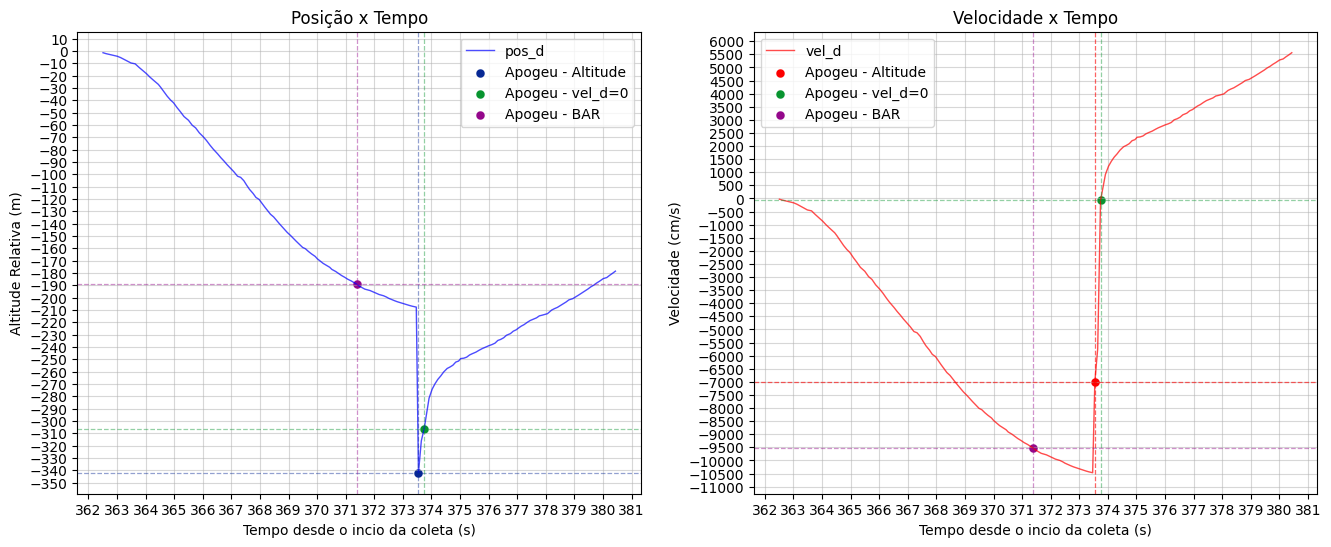

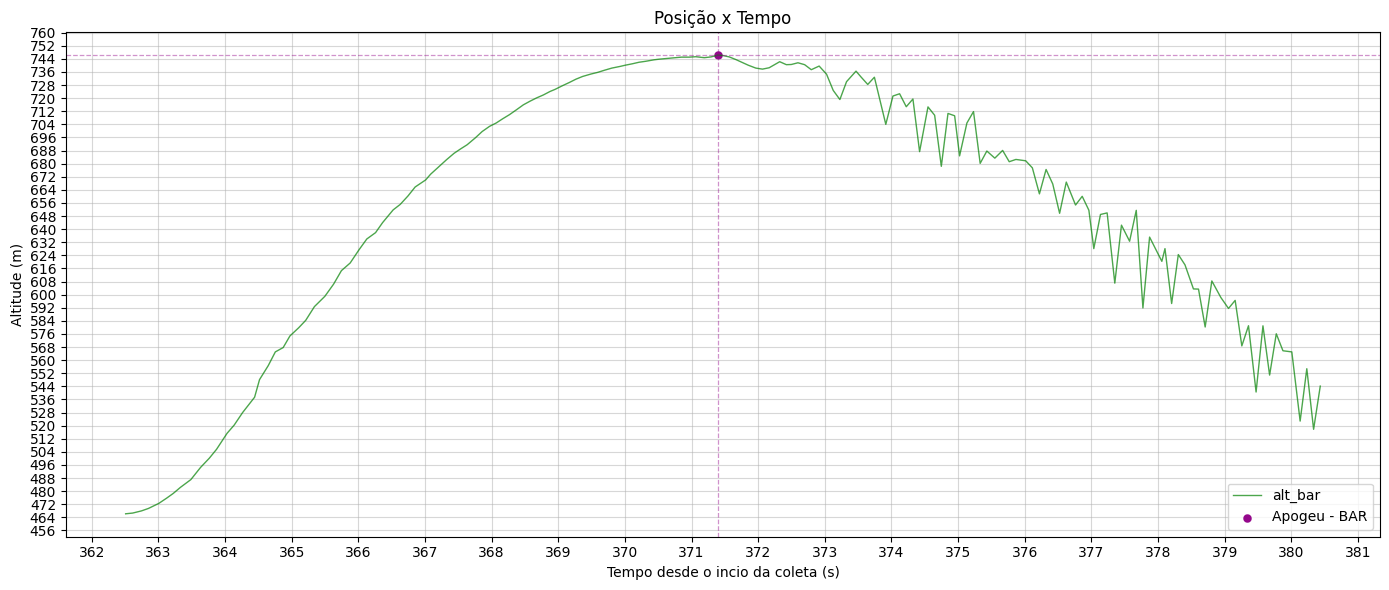

In [321]:
df_pos_d = df.loc[df["flight_state"] >= 2, ["time_interval", "pos_d","vel_d", "timestamp_ms", "alt_bar", "alt_gps"]].copy()
df_pos_d["pos_d"] = df_pos_d["pos_d"]
df_pos_d["vel_d"] = df_pos_d["vel_d"]
df_pos_d["time_interval"] = df_pos_d["time_interval"]/1000

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig2, axes2 = plt.subplots(1, figsize=(14, 6))

# Coluna 1
axes[0].plot(df_pos_d["time_interval"], df_pos_d["pos_d"], color="b", linestyle="-", label="pos_d", alpha=0.7, linewidth=1)

#Detalhes
axes[0].set_xlabel("Tempo desde o incio da coleta (s)")
axes[0].set_ylabel("Altitude Relativa (m)")
axes[0].grid(True, alpha=0.5)
axes[0].set_title("Posição x Tempo")

# Configuracao eixo
axes[0].xaxis.set_major_locator(ticker.MaxNLocator(20))
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(40))

#Coluna 2
axes[1].plot(df_pos_d["time_interval"], df_pos_d["vel_d"], color="r", linestyle="-", label="vel_d", alpha=0.7, linewidth=1)

#Detalhes
axes[1].set_xlabel("Tempo desde o incio da coleta (s)")
axes[1].set_ylabel("Velocidade (cm/s)")
axes[1].grid(True, alpha=0.5)
axes[1].set_title("Velocidade x Tempo")

# Configuracao eixo
axes[1].xaxis.set_major_locator(ticker.MaxNLocator(20))
axes[1].yaxis.set_major_locator(ticker.MaxNLocator(40))

#Marcando o apogeu
df_apogeu = (df[["timestamp_ms","time_interval","pos_d","vel_d","alt_bar", "alt_gps", "gps_available"]]).copy() #Usamos o dataframe completo para determinar o apogeu


id_ap_pos = df_apogeu["pos_d"].idxmin() #Retorna o id do maior valor na coluna "pos_d"
id_ap_alt_bar = df_apogeu["alt_bar"].idxmax() #Retorna o id do maior valor na coluna "alt_bar"
id_ap_alt_gps = df_apogeu["alt_gps"].idxmax() #Retorna o id do maior valor na coluna "alt_bar"

alt_rel_ap = df_apogeu["pos_d"].min()
alt_rel_ap_bar = df_apogeu["pos_d"].iloc[id_ap_alt_bar]

alt_bar_ap = df_apogeu["alt_bar"].max()
alt_bar_ap_pos = df_apogeu["alt_bar"].iloc[id_ap_pos]

alt_gps_ap_bar = df_apogeu["alt_gps"].iloc[id_ap_alt_bar]
alt_gps_ap_pos = df_apogeu["alt_gps"].iloc[id_ap_pos]

vel_d_ap = df_apogeu["vel_d"].iloc[id_ap_pos]
vel_d_ap_bar = df_apogeu["vel_d"].iloc[id_ap_alt_bar]

timestamp_ap_pos = df_apogeu["timestamp_ms"].iloc[id_ap_pos]
timestamp_ap_alt_bar = df_apogeu["timestamp_ms"].iloc[id_ap_alt_bar]
timestamp_ap_alt_gps = df_apogeu["timestamp_ms"].iloc[id_ap_alt_gps]

time_interval_ap_pos = df_apogeu["time_interval"].iloc[id_ap_pos]
time_interval_ap_alt_bar = df_apogeu["time_interval"].iloc[id_ap_alt_bar]
time_interval_ap_alt_gps = df_apogeu["time_interval"].iloc[id_ap_alt_gps]

time_interval_ap_pos /= 1000
time_interval_ap_alt_bar /= 1000

axes[0].axvline(x=time_interval_ap_pos, color="#07289470", linewidth = 0.9, linestyle = "--")
axes[0].axhline(y=alt_rel_ap, color="#07289470", linewidth = 0.9, linestyle = "--")
axes[0].scatter(x=time_interval_ap_pos, y=alt_rel_ap, color="#07289470", linewidths= 0.1, alpha=1, label = "Apogeu - Altitude")

axes[1].axvline(x=time_interval_ap_pos, color="#FD00009C", linewidth = 0.9, linestyle = "--")
axes[1].axhline(y=vel_d_ap, color="#FD00009C", linewidth = 0.9, linestyle = "--")
axes[1].scatter(x=time_interval_ap_pos, y=vel_d_ap, color="#FD00009C", linewidths= 0.1, alpha=1, label = "Apogeu - Altitude")

#Encontrando pontos com vel_d = 0
indices_cruzamento = []
for i in range(len(df_pos_d)-1):
    if df_pos_d["vel_d"].iloc[i] <= 0 and df_pos_d["vel_d"].iloc[i + 1] > 0:
        indices_cruzamento.append(i)

time_interval_vel0 = df_pos_d["time_interval"].iloc[indices_cruzamento[0]]
timestamp_vel0 = df_pos_d["timestamp_ms"].iloc[indices_cruzamento[0]]
alt_rel_vel0 = df_pos_d["pos_d"].iloc[indices_cruzamento[0]]
alt_gps_vel0 = df_pos_d["alt_gps"].iloc[indices_cruzamento[0]]
alt_bar_vel0 = df_pos_d["alt_bar"].iloc[indices_cruzamento[0]]
vel_d_vel0 = df_pos_d["vel_d"].iloc[indices_cruzamento[0]]

#Marcando pontos com vel_d = 0
axes[0].axvline(x=time_interval_vel0, color="#07942F6F", linewidth = 0.9, linestyle = "--")
axes[0].axhline(y=alt_rel_vel0, color="#07942F6F", linewidth = 0.9, linestyle = "--")
axes[0].scatter(x=time_interval_vel0, y=alt_rel_vel0, color="#07942F6F", linewidths= 0.1, alpha=1, label = "Apogeu - vel_d=0")

axes[1].axvline(x=time_interval_vel0, color="#07942F6F", linewidth = 0.9, linestyle = "--")
axes[1].axhline(y=vel_d_vel0, color="#07942F6F", linewidth = 0.9, linestyle = "--")
axes[1].scatter(x=time_interval_vel0, y=vel_d_vel0, color="#07942F6F", linewidths= 0.1, alpha=1, label = "Apogeu - vel_d=0")

#Alt_Bar
axes2.plot(df_pos_d["time_interval"], df_pos_d["alt_bar"], color="g", linestyle="-", label="alt_bar", alpha=0.7, linewidth=1)

#Detalhes
axes2.set_xlabel("Tempo desde o incio da coleta (s)")
axes2.set_ylabel("Altitude (m)")
axes2.grid(True, alpha=0.5)
axes2.set_title("Posição x Tempo")

# Configuracao eixo
axes2.xaxis.set_major_locator(ticker.MaxNLocator(20))
axes2.yaxis.set_major_locator(ticker.MaxNLocator(40))

#Marcando Apogeu - Bar
axes[0].axvline(x=time_interval_ap_bar, color="#94078B70", linewidth = 0.9, linestyle = "--")
axes[0].axhline(y=alt_rel_ap_bar, color="#94078B70", linewidth = 0.9, linestyle = "--")
axes[0].scatter(x=time_interval_ap_bar, y=alt_rel_ap_bar, color="#94078B70", linewidths= 0.1, alpha=1, label = "Apogeu - BAR")

axes[1].axvline(x=time_interval_ap_bar, color="#94078B70", linewidth = 0.9, linestyle = "--")
axes[1].axhline(y=vel_d_ap_bar, color="#94078B70", linewidth = 0.9, linestyle = "--")
axes[1].scatter(x=time_interval_ap_bar, y=vel_d_ap_bar, color="#94078B70", linewidths= 0.1, alpha=1, label = "Apogeu - BAR")

axes2.axvline(x=time_interval_ap_bar, color="#94078B70", linewidth = 0.9, linestyle = "--")
axes2.axhline(y=alt_ap_bar, color="#94078B70", linewidth = 0.9, linestyle = "--")
axes2.scatter(x=time_interval_ap_bar, y=alt_ap_bar, color="#94078B70", linewidths= 0.1, alpha=1, label = "Apogeu - BAR")

print("Apogeu por altitude - Estimado com POS_D:")
print(f"Tempo apogeu: {time_interval_ap_pos}s desde o incio da coleta")
print(f"Timestamp apogeu: {timestamp_ap_pos}ms")
print(f"Altitude Relativa apogeu (AGL): {alt_rel_ap}m") #Vai ser negativo pois o eixo "d" no sistema NED aponta pra baixo
if df_apogeu["gps_available"].iloc[id_ap_pos] == 1:
    print(f"Altitude apogeu gps (ASL): {alt_gps_ap_pos}m")
else:
    print(f"Altitude apogeu gps (ASL): SEM SINAL")
    
print(f"Altitude apogeu barometro (ASL): {alt_bar_ap_pos}m")
print(f"Velocidade Vertical apogeu: {vel_d_ap}cm/s ou {round(vel_d_ap/100,4)}m/s")
print("-------------------------------------------------")

print("Apogeu por altitude - Estimado com Barômetro:")
print(f"Tempo apogeu: {time_interval_ap_alt_bar}s desde o incio da coleta")
print(f"Timestamp apogeu: {timestamp_ap_bar}ms")
print(f"Altitude Relativa apogeu (AGL): {alt_rel_ap_bar}m") #Vai ser negativo pois o eixo "d" no sistema NED aponta pra baixo
if df_apogeu["gps_available"].iloc[id_ap_alt_bar] == 1:
    print(f"Altitude apogeu gps (ASL): {alt_gps_ap_bar}m")
else:
    print(f"Altitude apogeu gps (ASL): SEM SINAL")
    
print(f"Altitude apogeu barometro (ASL): {alt_bar_ap}m")
print(f"Velocidade Vertical apogeu: {vel_d_ap_bar}cm/s ou {round(vel_d_ap_bar/100,4)}m/s")
print("-------------------------------------------------")

print("Apogeu quando vel_vertical é 0:")
print(f"Tempo apogeu: {time_interval_vel0}s apos o lancamento")
print(f"Timestamp apogeu: {timestamp_vel0}ms")
print(f"Altitude Relativa apogeu (AGL): {alt_rel_vel0}m") #Vai ser negativo pois o eixo "d" no sistema NED aponta pra baixo
if df_apogeu["gps_available"].iloc[indices_cruzamento[0]] == 1:
    print(f"Altitude apogeu gps (ASL): {alt_gps_vel0}m")
else:
    print(f"Altitude apogeu gps (ASL): SEM SINAL")
    
print(f"Altitude apogeu barometro (ASL): {alt_bar_vel0}m")
print(f"Velocidade Vertical apogeu: {vel_d_vel0}cm/s ou {round(vel_d_vel0/100,4)}m/s")
print("-------------------------------------------------")
axes[0].legend()
axes[1].legend()
axes2.legend()
plt.tight_layout()
plt.show()

Num lançamento vertical o ponto de apogeu é caracterizado pelo ponto em que a velocidade obliquo é 0, iniciando um movimento de queda em que a velocidade vertical se torna negativa

- Note que em 373.544s a posição vertical atinge um pico enquanto a velocidade vertical começa a se reduzir, chegando a 0 e alcançando um valor negativo
- Note que o apogeu calculado pelo barômetro está muito longe da vel_rel = 0 e do apogeu de altitude relativa, portanto não vamos usá-lo como referência
- Note que o apogeu calculado pela maior altitude (com base em pos_d) e o apogeu físico (vel_d = 0) estão bem próximos, logo usaremos a pos_d como referência para definir o apogeu

Apogeu:


    Tempo apogeu: 373.544s desde o incio da coleta
    Timestamp apogeu: 399033ms
    Altitude Relativa apogeu (AGL): -341.8969m
    Altitude apogeu gps (ASL): SEM SINAL
    Altitude apogeu barometro (ASL): 732.9m
    Velocidade Vertical apogeu: -7004.5176cm/s ou -70.0452m/s


Observando que a variação da velocidade vertical (aceleração vertical) se altera após o apogeu e que a curva é suavizada a partir de 374s podemos supor que nesse período há uma abertura de paraquedas (o momento ideal para lançar um paraquedas é no apogeu, uma vez que quando há uma grande aceleracao (subida - pré burnout e queda livre) o paraquedas pode ter dificuldade em abrir ou ser danificado devido à força à qual será submetido)

Durante a ascensão a gravidade(9.8m/s²) + arrasto(drag) apontam para baixo, já durante a queda o arrasto(drag) contrapõe a gravidade, até que eles se igualam e o foguete alcança velocidade terminal(aceleração=0, então deixa de ganhar velocidade). O apogeu é o único momento em que a única força que atua verticalmente no foguete é a gravidade e portanto, logo após ele é o momento ideal de soltar o paraquedas

- A queda de pressão no apogeu

Pressão no apogeu: 928.26 hPa


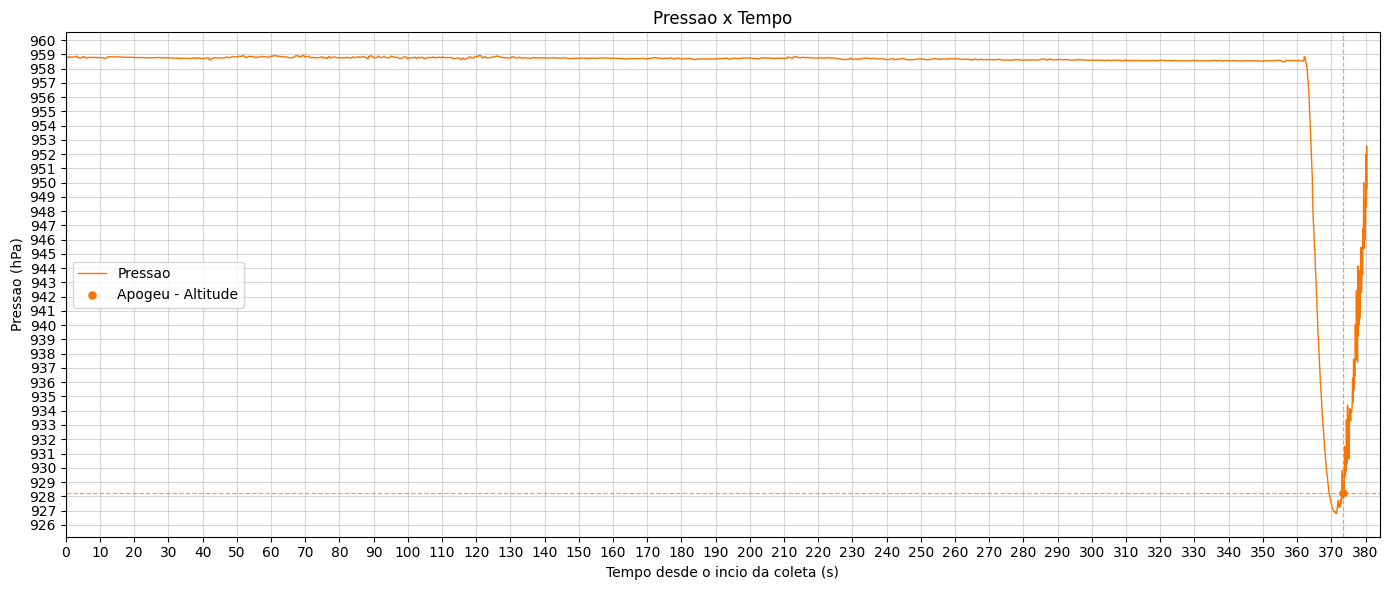

In [322]:
plt.figure(figsize=(14,6))
plt.plot(df["time_interval"]/1000, df["pressure"], color ="#F97400FF", linestyle="-",label ="Pressao", alpha = 1, linewidth = 1)

#Marcando o apogeu
df_apogeu = (df[["timestamp_ms","time_interval","pos_d","pressure"]]).copy() #Usamos o dataframe completo para determinar o apogeu


id_ap = df_apogeu["pos_d"].idxmin() #Retorna o id do maior valor na coluna "pos_d"

timestamp_ap = df_apogeu["timestamp_ms"].iloc[id_ap]

time_interval_ap = df_apogeu["time_interval"].iloc[id_ap]

time_interval_ap /= 1000

pressure_ap = df_apogeu["pressure"].iloc[id_ap]

plt.axvline(x=time_interval_ap, color="#F97400AB", linewidth = 0.9, linestyle = "--")
plt.axhline(y=pressure_ap, color="#F97400AB", linewidth = 0.9, linestyle = "--")
plt.scatter(x=time_interval_ap, y=pressure_ap, color="#F97400AB", linewidths= 0.1, alpha=1, label = "Apogeu - Altitude")

plt.title("Pressao x Tempo")
plt.xlabel("Tempo desde o incio da coleta (s)")
plt.ylabel("Pressao (hPa)")
plt.xlim(0,1.01*(df["time_interval"].max())/1000)

plt.grid(True, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(45))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(36))

print(f"Pressão no apogeu: {df_apogeu["pressure"].iloc[id_ap]} hPa")
plt.show()

- Para uma análise mais detelhada seria preciso mais informações sobre o modelo do barômetro e a estrutura física do foguete.

- Contudo, esse comportamento de queda de pressão próxima ao apogeu pode ser uma consequência do fenômeno de "snatch force", que é uma força gerada pela desaceleração brusca, comum em foguetes durante o evento de abertura do paraquedas drogue. Essa força faz com que a pressão do ar dentro do compartimento não equalize instantâneamente com a pressão externa e causa uma queda TRANSITÓRIA na pressão, assim como pode ser visto no gráfico

- Essa queda de pressão também explica o porquê do offset entre as medidas de altitude do barômetro e gps estar tão alto nesse ponto, uma vez que uma queda de pressão poderia gerar uma leitura errada no barômetro.

### Burnout do motor

- Podemos estimar o burnout do motor como o momento em que o motor para dar empuxo ao foguete. Para medir isso vamos encontrar o ponto em que a aceleração é 0

- Usaremos que acc_resultante = √(acc_n² + acc_e² + acc_d²), portanto teremos um gráfico da MAGNITUDE da acelereção, sendo este totalmente positivo.

- Vamos plottar a acc vertical também. Além de ser a aceleração mais prevalente, poderemos observar claramente o ponto em que a aceleração muda de sentido

- Durante o vôo as seguintes forças atuam sobre o foguete:

1) Empuxo do motor - A favor do movimento
2) Arrasto - Contra o movimento
3) Gravidade - Sempre para baixo
4) Peso (como não temos dados suficientes será desconsiderado) - Contra o movimento

- Vamos analisar 3 pontos para termos um burnout preciso:

1) 10% da aceleração resultante máxima restante (como não conseguimos remover o arrasto usamos 10% como um threshold)
2) Ponto em que a aceleração resultante é próxima 0 (quando o empuxo é removido a aceleração fica negativa, portanto num gráfico de MAGNITUDE esse ponto será o mais próximo de 0, antes de uma subida)
3) Menor derivada negativa (quando o empuxo é removida há uma mudança drástica na variação da aceleração ao longo do tempo)

In [323]:
def detectar_burnout(df):
    resultados = {}
    #Restringir os dados para quando o foguete está voando
    df_burnout = df[df["flight_state"] >= 2].copy()

    #Calculando a aceleração resultante
    df_burnout["acc_resultante"] = np.sqrt((df_burnout["acc_n"]**2) + 
                                           (df_burnout["acc_e"]**2) + 
                                           (df_burnout["acc_d"]**2))
    df_burnout = df_burnout.reset_index(drop=True)

    #Pico de aceleração
    id_acc_max = df_burnout["acc_resultante"].idxmax()
    acc_max = df_burnout["acc_resultante"].iloc[id_acc_max]    

    # 1) Queda da aceleração para 10%
    threshold = acc_max * 0.1
    df_post_acc_max = df_burnout.iloc[id_acc_max:]
    below_threshold = df_post_acc_max[df_post_acc_max["acc_resultante"] < threshold]
    below_threshold = below_threshold.reset_index(drop=True)

    resultados["time_interval_acc_below_10"] = (below_threshold["time_interval"].iloc[0])
    resultados["acc_below_10"] = (below_threshold["acc_resultante"].iloc[0])

    # 2) Acc_resultante é proxima de 0
    id_first_prox_0 = df_burnout["acc_resultante"].idxmin() #primeiro termo que cruza 0
    resultados["time_interval_acc_resultante_0"] = (df_burnout["time_interval"].loc[id_first_prox_0])
    resultados["acc_resultante_0"] = (df_burnout["acc_resultante"].loc[id_first_prox_0])
        
    # 3) Maior desaceleração
    df_burnout["acc_dt"] = df_burnout["acc_resultante"].diff()
    id_max_decel = df_burnout["acc_dt"].idxmin() #A maior desaceleração é a menor derivada negativa

    resultados["time_interval_max_decel"] = (df_burnout["time_interval"].loc[id_max_decel])
    resultados["max_decel"] = (df_burnout["acc_resultante"].loc[id_max_decel])

    return resultados, df_burnout

Resumo
---------------------------------------
Time Interval Burnout Below_10: 365.105s
Time Interval Burnout Acc. resultante 0: 365.629s
Time Interval Burnout Menor Derivada Negativa (max_decel): 364.031s
Altitude Relativa Burnout Below_10: -46.1497m
Altitude Relativa Acc resultante 0: -60.2222m
Altitude Relativa Menor Derivada Negativa (max_decel): -18.4842m
---------------------------------------
Info Burnout Below_10: 
timestamp_ms         390594
gnss_time          144303.8
lat              -21.941568
lon               -48.95269
alt_gps               509.6
gnss_fix                  1
gnss_sats                 6
alt_bar              579.77
pressure             945.52
temperature           34.24
pos_n                1.8714
pos_e               -3.5424
pos_d              -46.1497
vel_n               -0.1062
vel_e                0.3483
vel_d            -2272.6326
acc_n               -1.4292
acc_e                3.6377
acc_d                2.6921
acc_x_raw           -0.3442
acc_y_raw    

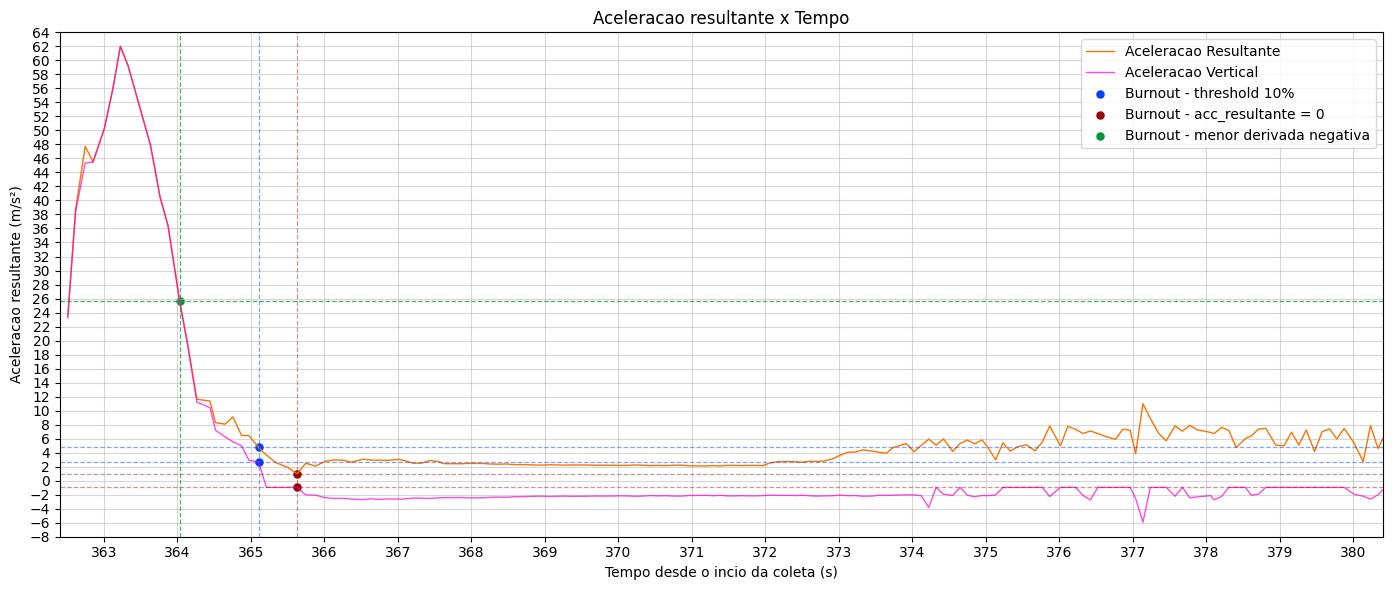

In [324]:
plt.figure(figsize=(14,6))

resultados, df_burnout = detectar_burnout(df) #df_burnout contém valores apenas num flight_state >= 2

time_interval_burn_below_10 = (resultados["time_interval_acc_below_10"] / 1000)
acc_below_10 = resultados["acc_below_10"]
df_below_10 = df_burnout[df_burnout["time_interval"] == (time_interval_burn_below_10 * 1000)]
pos_d_below_10 = df_below_10["pos_d"].iloc[0]
acc_d_below_10 = df_below_10["acc_d"].iloc[0]

if "acc_resultante_0" in resultados:
    time_interval_acc_resultante_0 = (resultados["time_interval_acc_resultante_0"] / 1000)
    acc_acc_resultante_0 = resultados["acc_resultante_0"]
    df_acc_resultante_0 = df_burnout[df_burnout["time_interval"] == (time_interval_acc_resultante_0 * 1000)]
    pos_d_acc_resultante_0 = df_acc_resultante_0["pos_d"].iloc[0]
    acc_d_acc_resultante_0 = df_acc_resultante_0["acc_d"].iloc[0]

time_interval_max_decel = (resultados["time_interval_max_decel"] / 1000)
acc_max_decel = resultados["max_decel"]
df_max_decel = df_burnout[df_burnout["time_interval"] == (time_interval_max_decel * 1000)]
pos_d_max_decel = df_max_decel["pos_d"].iloc[0]

print(f"Resumo\n---------------------------------------")
print(f"Time Interval Burnout Below_10: {time_interval_burn_below_10}s")
if "acc_resultante_0" in resultados:
    print(f"Time Interval Burnout Acc. resultante 0: {time_interval_acc_resultante_0}s")
print(f"Time Interval Burnout Menor Derivada Negativa (max_decel): {time_interval_max_decel}s")
print(f"Altitude Relativa Burnout Below_10: {pos_d_below_10}m")
if "acc_resultante_0" in resultados:
    print(f"Altitude Relativa Acc resultante 0: {pos_d_acc_resultante_0}m")
print(f"Altitude Relativa Menor Derivada Negativa (max_decel): {pos_d_max_decel}m")
print("---------------------------------------")

print(f"Info Burnout Below_10: \n{df_below_10.iloc[0]}\n---------------------------------------")
if "acc_resultante_0" in resultados:
    print(f"Info Burnout Acc. resultante 0: \n{df_acc_resultante_0.iloc[0]}\n---------------------------------------")
print(f"Info Burnout Menor Derivada Negativa (max_decel): \n{df_max_decel.iloc[0]}\n---------------------------------------")

plt.plot(df_burnout["time_interval"]/1000, df_burnout["acc_resultante"], color ="#F97400FF", linestyle="-",label ="Aceleracao Resultante", alpha = 1, linewidth = 1)
plt.plot(df_burnout["time_interval"]/1000, df_burnout["acc_d"], color ="#F900CFFF", linestyle="-",label ="Aceleracao Vertical", alpha = 0.7, linewidth = 1)
plt.title("Aceleracao resultante x Tempo")
plt.xlabel("Tempo desde o incio da coleta (s)")
plt.ylabel("Aceleracao resultante (m/s²)")

#Burnout - Threshold 10%
plt.axvline(x=time_interval_burn_below_10, color="#0042F97A", linewidth = 0.9, linestyle = "--")
plt.axhline(y=acc_below_10, color="#0042F97A", linewidth = 0.9, linestyle = "--")
plt.scatter(x=time_interval_burn_below_10, y=acc_below_10, color="#0042F97A", linewidths= 0.1, alpha=1, label = "Burnout - threshold 10%")
plt.axhline(y=acc_d_below_10, color="#0042F97A", linewidth = 0.9, linestyle = "--")
plt.scatter(x=time_interval_burn_below_10, y=acc_d_below_10, color="#0042F97A", linewidths= 0.1, alpha=1)

#Burnout - Acc resultante = 0
if "acc_resultante_0" in resultados:
    plt.axvline(x=time_interval_acc_resultante_0, color="#9407076E", linewidth = 0.9, linestyle = "--")
    plt.axhline(y=acc_acc_resultante_0, color="#9407076E", linewidth = 0.9, linestyle = "--")
    plt.scatter(x=time_interval_acc_resultante_0, y=acc_acc_resultante_0, color="#9407076E", linewidths= 0.1, alpha=1, label = "Burnout - acc_resultante = 0")
    plt.axhline(y=acc_d_acc_resultante_0, color="#9407076E", linewidth = 0.9, linestyle = "--")
    plt.scatter(x=time_interval_acc_resultante_0, y=acc_d_acc_resultante_0, color="#9407076E", linewidths= 0.1, alpha=1)

#Burnout - Maior desaceleracao
plt.axvline(x=time_interval_max_decel, color="#07943BB6", linewidth = 0.9, linestyle = "--")
plt.axhline(y=acc_max_decel, color="#07943BB6", linewidth = 0.9, linestyle = "--")
plt.scatter(x=time_interval_max_decel, y=acc_max_decel, color="#07943BB6", linewidths= 0.1, alpha=1, label = "Burnout - menor derivada negativa")

plt.grid(True, alpha= 0.5)
plt.tight_layout()
plt.legend()

plt.xlim(362.4, 380.4)
plt.ylim(-8, 64)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(20))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(40))

plt.show()

- Ao analisar o gráfico vemos que nossa medição por menor derivada negativa não foi muito efetiva. Esse dado apresenta uma variação muito grande em relação às outras técnicas de medição e não condiz com a análise física do burnout.

- Vamos usar os valores de burnout encontrados com método de identificação com base aceleração efetiva próxima de 0. Além de ser o método mais confiável, por estar respaldado no fenômeno físico da mudança do sentido da aceleração com o fim do empuxo, também está próximo do valor calculado usando uma threshold de 10% da aceleração total

Burnout:


    Tempo Burnout: 365.629s desde o incio da coleta
    Timestamp Burnout: 391118ms
    Altitude Relativa Burnout (AGL): -60.2222m
    Altitude Burnout GPS (ASL): 509.8m
    Altitude Burnout Barometro (ASL): 606.41m
    Velocidade Vertical Burnout: -2984.6794cm/s ou -29.8468m/s

### Abertura do paraquedas
- É um ponto complexo de ser medido precisamente dispondo apenas dos dados de vôo

# Condições base da competição
A princípio precisamos estabelecer as condições base às quais o foguete estava submetido durante a coleta de dados


### 1) Environment
-Sabemos que a LASC ocorreu entre 05/11/2025 e 08/11/2025, o que representa a semana de GPS número 2391. Por ser um valor baixo assumiu-se que o "gnss_time" nos dados do foguete represente "GPS seconds of week", então usando uma calculadora online foi estimado que o lançamento ocorreu em:

Calendário GPS: https://geodesy.noaa.gov/CORS/resources/gpscals.shtml

Calculadora: https://www.labsat.co.uk/index.php/en/gps-time-calculator

    Data: 03/11/2025 16:05:01

-Analisando a 6th Space Challenge, sabemos que para esse ano o local de lançamento foi diferente de anos anteriores, o "Sugarcane Launch Range" em "Lacanga - SP", obtendo as coordenadas pelos dados de telemetria do NASHIRA temos:

    Latitude: -21.94156456
   
    Longitude: -48.95269394

-Para a altitude vamos utilizar a altitude registrada pelo GPS do NASHIRA no momento da decolagem

    Altitude mínima: 509.16m
    Altitude máxima: 640.3m
    

In [325]:
#Retirando os valores de 0 medidos pelo GPS (GPS desligado)
df1 = df.copy()
df1["lat"] = df1["lat"].replace(0,np.nan) 
df1["lon"] = df1["lon"].replace(0,np.nan) 
df1 = df1.dropna(subset=["lat","lon"])

print(f"Latitude: {df1['lat'].iloc[0]}")
print(f"Longitude: {df1['lon'].iloc[0]}")

Latitude: -21.94156456
Longitude: -48.95269394


- Para a pressão usaremos os dados do NASHIRA:

In [326]:
print(f"Pressão minima: {df["pressure"].min()}")
print(f"Pressão máxima: {df["pressure"].max()}")

Pressão minima: 926.77
Pressão máxima: 958.94


- Para criar o environment foi utilizado uma reanalysis ERA5 feita pela ECMWF.

- A reanalisys utilizada pode ser encontrada no link: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels?tab=download

- Foram utilizados os seguintes critérios:

Variable: Geopotential, Temperature, U-component of wind, V-component of wind

Data: 08/11/2025, 12:00

Pressure level: 925hPa - 975hPa

North:    -21.80

West:     -49.10

South:    -22.10

East:     -48.80


In [327]:
env = Environment(latitude=-21.94156456, longitude=-48.95269394, elevation=509.16)
launch_day = datetime.datetime(2025,11,3,16,0,0)
filename = "Environment\EuroC pressure reanalysis - 2025 08 11.nc"

print(f"data de lançamento {launch_day}")
env.set_date((launch_day.year, launch_day.month, launch_day.day, launch_day.hour))
print(launch_day.year)
print(launch_day.month)
print(launch_day.day)
print(launch_day.hour)
env.set_atmospheric_model(
    type="reanalysis",
    file=filename,
    dictionary="ECMWF"
)

env.plots.atmospheric_model()

data de lançamento 2025-11-03 16:00:00
2025
11
3
16


<>:3: SyntaxWarning: invalid escape sequence '\E'
<>:3: SyntaxWarning: invalid escape sequence '\E'
C:\Users\Enzo\AppData\Local\Temp\ipykernel_10736\3237078459.py:3: SyntaxWarning: invalid escape sequence '\E'
  filename = "Environment\EuroC pressure reanalysis - 2025 08 11.nc"


ValueError: The chosen launch time '2025-11-03-16: UTC' is not available in the provided file. Please choose a time within the range of the file, which starts at '2025-11-08-11 UTC'.

In [ ]:
env.info()

### 2) Motor

Na categoria de 500m da LASC competem apenas foguetes com combustível sólido, então como foi indicado usaremos o Calisto como base.

Todas as informações do calisto foram utilizadas no passo-a-passo a seguir: https://docs.rocketpy.org/en/latest/user/first_simulation.html

Assim, as coordenadas utilizadas tem o mesmo ponto de referência.

    -Motor: Cesaroni_M1670

https://github.com/RocketPy-Team/RocketPy/blob/master/data/motors/cesaroni/Cesaroni_M1670.eng

In [ ]:
Pro75M1670 = SolidMotor(
    thrust_source="Motor/Cesaroni_M1670.eng",
    dry_mass=1.815,
    dry_inertia=(0.125, 0.125, 0.002),
    nozzle_radius=33 / 1000,
    grain_number=5,
    grain_density=1815,
    grain_outer_radius=33 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.397,
    center_of_dry_mass_position=0.317,
    nozzle_position=0,
    burn_time=3.9,
    throat_radius=11 / 1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

In [ ]:
Pro75M1670.info()

### 3) Rocket
Seguiremos usando o Calisto como base

É importante salientar o que cada característica passada indica:

    -Radius: Raio do foguete
    -Mass: Massa sem o motor (kg)
    -Inertia: Tupla (i1,i2,i3) da inércia em relação ao centro de massa sem o motor. i1 e i2 são a inércia em relação aos eixos perpendiculares ao foguete e i3 ao eixo paralelo/central do foguete
    -Power_off_drag: Drag curve em csv do motor desligado
    -Power_on_drag: Drag curve em csv do motor ligado (se não tiver pode usar do desligado assumindo possíveis imprecisões na simulação)
    -Center_of_mass_without_a_motor: Coordendas do centro de massa sem o motor
    -Coordinate_system_orientation: Orientação do sistema de coordenadas
*É possível passar a inércia com cada componente dos tensores checar https://docs.rocketpy.org/en/latest/user/rocket/rocket_usage.html#rocketusage para mais info

In [ ]:
calisto = Rocket(
    radius=127 / 2000,
    mass=14.426,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="Rocket/calisto/powerOffDragCurve.csv",
    power_on_drag="Rocket/calisto/powerOnDragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

- Adicionando o motor

In [ ]:
calisto.add_motor(Pro75M1670, position=-1.255)

- Adicionando componentes aerodinâmicos

Usamos um cone de ponta, 4 barbatanas e 1 cauda

In [ ]:
nose_cone = calisto.add_nose(
    length=0.55829, kind="von karman", position=1.278
)

fin_set = calisto.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
    airfoil=("Fins/NACA0012-radians.txt","radians"),
)

tail = calisto.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)

- Checando a estabilidade

Valores muito altos ou negativos de Static Margin indicam um foguete com estabilidade inedequada, o que gerará inconsistência na simulação

In [ ]:
calisto.plots.static_margin()

- Checando se os componentes foram acoplados de maneira correta

In [ ]:
calisto.draw()

- Simulando o vôo

O regulamento da LASC estipula: 

    Inclinação de lançamento: 80°+/- 5°
    Tamanho dos trilhos: 4m

In [ ]:
Image(filename="Imagens complementares/Inclinação dos trilhos.png")

In [ ]:
Image(filename="Imagens complementares/Tamanho dos trilhos.png")

In [ ]:
simulacao = Flight(
    rocket = calisto,
    environment= env,
    rail_length=4.0,
    inclination= 80,
    heading= 0 #direção horizontal final do voo (Norte = 0, Leste = 90,...)
)

In [ ]:
simulacao.plots.trajectory_3d() #projeção em 3d

simulacao.plots.linear_kinematics_data()

In [ ]:
simulacao.info()

In [ ]:
df_apagar = df[df["vel_d"] == 0].copy() #Copiamos só o flight state atual